# Use case -  Oddball EEG ERP classification

This notebook is a very crude and straightforward demonstration of how one can prototype and configurate timeflux pipelines (graphs) offline, using recordings. 

Here, we work on EEG data acquired from [Unicorn headset](https://www.unicorn-bi.com/) during  an [Odddball paradigm](https://github.com/timeflux/timeflux_ui/blob/master/apps/oddball.yaml). In order to take advantage of mne very nice visualization tools, we'll be jongling from pandas DataFrame, and DataArray to mne objects. 

This notebook consists in: 
- loading the eeg signal and events from the hdf5 file
- jump in mne world to visualize the power spectral density (check for dead channels and line noise) 
- use a branch to load the graph and run it 100% offline 
- eventually, jump again in mne world, by converting epochs into mne objects to visualize avergage ERPs
- use a branch and timeflux testing helpers to loop amongst chunk to mimick online processing, epoching and fit/predict of EEG data
- plot the prediction results

## Material
### EEG Device
- Setup:
    - unicorn headset:
        - dry or wet electrodes
        - channels: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    - photodiode
    
<img src="img/unicorn_headset.jpg" alt="headset" width="200"/>

### Oddball protocole

- Visual Oddball
    - 1200 stim
    - 167 deviants, 733 standards
    
```
$ git clone https://github.com/timeflux/timeflux_ui
$ conda activate timeflux
$ pip install git+https://github.com/timeflux/timeflux_ui
$ cd apps
$ timeflux oddball.yaml
```
and then, open http://localhost:8000/oddball/ 

<img src="img/oddball.gif" width="200"/>

In [1]:
# In notebook
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import os 
from glob import glob
import pathlib

import json
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from timeflux.core.branch import Branch

from utils.tutorial_utils import load_standalone_graph, pandas_to_mne 
from utils.idisplay import pygments_css, display_yaml


## Load data of a recording session

In [2]:
fname = 'data/oddball_pierre_20191129-135714.hdf5'
with pd.HDFStore(fname) as store:
    print(store.keys())
    eeg = pd.read_hdf(store, '/eeg')
    photodiode = pd.read_hdf(store, '/photodiode')
    events = pd.read_hdf(store, '/events')
    # deserialize events' data
    events.data = events.data.apply( lambda d: json.loads(d) if isinstance(d, str) else d)

['/eeg', '/events', '/photodiode']


<img src="img/oddball.gif" width="200"/>

In [3]:
events.head(15)

,data,hed,label
2019-11-29 13:58:50.668979980,NaN,NaN,session_begins
2019-11-29 13:58:50.669060059,{},NaN,training_begins
2019-11-29 13:58:50.669060059,NaN,NaN,block_begins
2019-11-29 13:58:50.669090088,"{'on': 100, 'off': 1208, 'deviant': 'False'}",NaN,stim_begins
2019-11-29 13:58:50.712405029,"{'on': 100, 'off': 1208, 'deviant': 'False'}",NaN,stim_on
2019-11-29 13:58:50.827695068,NaN,NaN,stim_off
2019-11-29 13:58:52.036715088,NaN,NaN,stim_ends
2019-11-29 13:58:52.036840088,"{'on': 100, 'off': 1247, 'deviant': 'False'}",NaN,stim_begins
2019-11-29 13:58:52.045820068,"{'on': 100, 'off': 1247, 'deviant': 'False'}",NaN,stim_on
2019-11-29 13:58:52.163500000,NaN,NaN,stim_off


## Convert pandas DataFrame to mne raw object 
Here, you go from pandas to mne format, only in order to take advantage of the visualizing tools. 
It should be notted that this conversion has nothing to do with timeflux online processing. 

In [4]:
raw = pandas_to_mne(eeg); 

/Users/raph/miniconda3/envs/sandbox/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/Users/raph/miniconda3/envs/sandbox/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/raph/PycharmProject/timeflux_workshops/utils/tutorial_utils.py:124: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise 

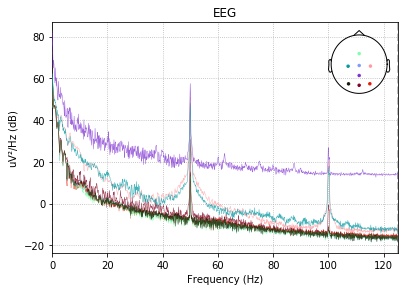

In [5]:
raw.plot_psd(); 

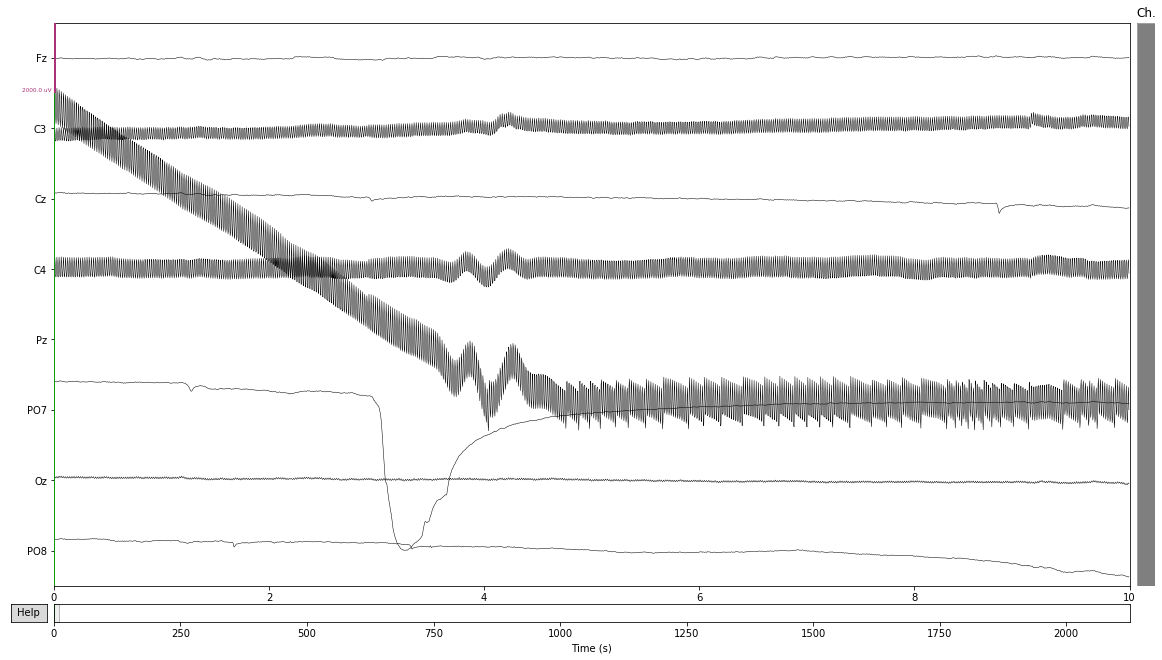

In [6]:
raw.plot(scalings=1e-3); 

# Load oddball graph and mimick the online loop
![oddball.png](img/oddball.png)

In [7]:
graph_path = 'graphs/erp_classification.yaml'
graph_standalone = load_standalone_graph(graph_path)
branch = Branch(graph_standalone)
display_yaml(graph_path); 

/Users/raph/miniconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


graphs : 
 - id : Process 
 nodes : 
 - id : sub 
 module : timeflux.nodes.zmq 
 class : Sub 
 params : 
 topics : [ raw_eeg , oddball_events ] 

 - id : dejitter 
 module : timeflux.nodes.dejitter 
 class : Interpolate 
 params : 
 rate : 250 
 method : nearest 

 - id : line 
 module : timeflux_dsp.nodes.filters 
 class : IIRLineFilter 
 params : 
 rate : 250 
 edges_center : [ 50 , 100 ] 

 - id : bandpass 
 module : timeflux_dsp.nodes.filters 
 class : IIRFilter 
 params : 
 rate : 250 
 frequencies : [ 1 , 30 ] 
 filter_type : bandpass 
 order : 3 

 - id : epochs 
 module : timeflux.nodes.epoch 
 class : Epoch 
 params : 
 before : 0.0 
 after : 0.6 
 event_trigger : stim_on 

 - id : to_xarray 
 module : timeflux.nodes.epoch 
 class : ToXArray 
 params : 
 output : DataArray 
 context_key : deviant 

 - id : gate_training 
 module : timeflux.nodes.gate 
 class : Gate 
 params : 
 event_opens : training_begins 
 event_closes : training_ends 

 - id : append_epochs 
 module : timeflux.nodes.accumulate 
 class : AppendDataArray 
 params : 
 dim : target 
 meta_keys : [ epochs_context , epochs_onset ] 

 - id : reshape_epochs 
 module : timeflux.nodes.xarray 
 class : Transpose 
 params : 
 dims : [ target , space , time ] 

 - id : fit 
 module : timeflux_ml.nodes.fit 
 class : Fit 
 params : 
 pipeline_steps : 
 cov : pyriemann.estimation.ERPCovariances 
 proj : pyriemann.tangentspace.TangentSpace 
 clf : pyriemann.classification.LogisticRegression 
 pipeline_params : 
 cov__estimator : oas 
 proj__metric : riemann 
 clf__solver : lbfgs 

 - id : cv 
 module : timeflux_ml.nodes.cross_validate 
 class : CrossValidate 
 params : 
 pipeline_steps : 
 cov : pyriemann.estimation.ERPCovariances 
 proj : pyriemann.tangentspace.TangentSpace 
 clf : pyriemann.classification.LogisticRegression 
 pipeline_params : 
 cov__estimator : oas 
 proj__metric : riemann 
 clf__solver : lbfgs 

 - id : predict 
 module : timeflux_ml.nodes.predict 
 class : PredictProba 

 - id : display 
 module : timeflux.nodes.debug 
 class : Display 
 edges : 
 - source : sub:raw_eeg 
 target : dejitter 
 - source : dejitter 
 target : line 
 - source : line 
 target : bandpass 
 - source : bandpass 
 target : epochs 
 - source : sub:oddball_events 
 target : epochs:events 
 - source : epochs:* 
 target : to_xarray 
 - source : to_xarray 
 target : reshape_epochs 
 - source : reshape_epochs 
 target : gate_training 
 - source : sub:oddball_events 
 target : gate_training:events 
 - source : gate_training 
 target : append_epochs 
 - source : append_epochs 
 target : fit 
 - source : append_epochs 
 target : cv 

 - source : fit:model 
 target : predict:model 
 - source : reshape_epochs 
 target : predict

Let us zoom in the `fit` node 

In [8]:
from timeflux_ml.nodes.fit import Fit
help(Fit)

Help on class Fit in module timeflux_ml.nodes.fit:

class Fit(timeflux.core.node.Node)
 |  Fit(*args, **kwargs)
 |  
 |  Construct and fit a sklearn Pipeline object
 |  
 |  This node first constructs a sklearn Pipeline object given ``pipeline_steps`` and
 |  ``pipeline_params``.
 |  Then, when data is received, the node calls the method `fit` of the pipeline object
 |  in a thread aside.
 |  Once the model has fitted, the node sends an event in data of output port with suffix 'events'
 |  and the fitted model in meta of output port with suffix 'model'.
 |  
 |  The fitting can be:
 |  
 |  - **supervised**:  if the training model requires to set `y` when calling the fit method,
 |      then parameter ``has_targets`` set to `True` and the data should be od type DataArray with
 |      dimension `target`.
 |  - **unsupervised**: if the training model does not require to set `y` when calling the fit method,
 |      then parameter ``has_targets`` should be set to `False` and data can be ei

In [9]:
branch._scheduler._nodes['fit']._pipeline_steps

{'cov': 'pyriemann.estimation.ERPCovariances',
 'proj': 'pyriemann.tangentspace.TangentSpace',
 'clf': 'pyriemann.classification.LogisticRegression'}

In [10]:
branch._scheduler._nodes['fit']._pipeline_params

{'cov__estimator': 'oas', 'proj__metric': 'riemann', 'clf__solver': 'lbfgs'}

In [11]:
graph_standalone

{'id': 'Process',
 'nodes': [{'id': 'dejitter',
   'module': 'timeflux.nodes.dejitter',
   'class': 'Interpolate',
   'params': {'rate': 250, 'method': 'nearest'}},
  {'id': 'line',
   'module': 'timeflux_dsp.nodes.filters',
   'class': 'IIRLineFilter',
   'params': {'rate': 250, 'edges_center': [50, 100]}},
  {'id': 'bandpass',
   'module': 'timeflux_dsp.nodes.filters',
   'class': 'IIRFilter',
   'params': {'rate': 250,
    'frequencies': [1, 30],
    'filter_type': 'bandpass',
    'order': 3}},
  {'id': 'epochs',
   'module': 'timeflux.nodes.epoch',
   'class': 'Epoch',
   'params': {'before': 0.0, 'after': 0.6, 'event_trigger': 'stim_on'}},
  {'id': 'to_xarray',
   'module': 'timeflux.nodes.epoch',
   'class': 'ToXArray',
   'params': {'output': 'DataArray', 'context_key': 'deviant'}},
  {'id': 'gate_training',
   'module': 'timeflux.nodes.gate',
   'class': 'Gate',
   'params': {'event_opens': 'training_begins',
    'event_closes': 'training_ends'}},
  {'id': 'append_epochs',
   '

# Run the graph as a branch
![oddball.png](img/oddball.png)

In [12]:
branch = Branch(graph_standalone)
branch.set_port('dejitter', port_id='i', data=eeg) 
branch.set_port('epochs', port_id='i_events', data=events)
branch.update(); 

In [13]:
epochs_data = branch.get_port('to_xarray', port_id='o').data
epochs_meta = branch.get_port('to_xarray', port_id='o').meta
epochs_data.coords

Coordinates:
  * target   (target) <U5 'False' 'False' 'False' ... 'False' 'True' 'False'
  * time     (time) timedelta64[ns] 00:00:00 00:00:00.004026 ... 00:00:00.600000
  * space    (space) object 'C3' 'C4' 'Cz' 'Fz' 'Oz' 'PO7' 'PO8' 'Pz'

## Eventually, use mne software to plot evoked traces 

In [14]:
from timeflux.helpers.mne import xarray_to_mne
epochs_mne = xarray_to_mne(epochs_data, epochs_meta, context_key='deviant', event_id={'True': 1, 'False': 0}, reporting='warn')
epochs_mne

<EpochsArray  |   1200 events (all good), 0 - 0.6 sec, baseline off, ~11.0 MB, data loaded,
 'False': 944
 'True': 256>

In [15]:
erp_list = list()
for condition in  ['False', 'True']:
    erp_list.append(epochs_mne[condition].average())

<ipython-input-16-ca2064c55205>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(erp_list, picks='Fz', colors={"1":'CornFlowerBlue', '2':'Crimson'}, axes=ax);


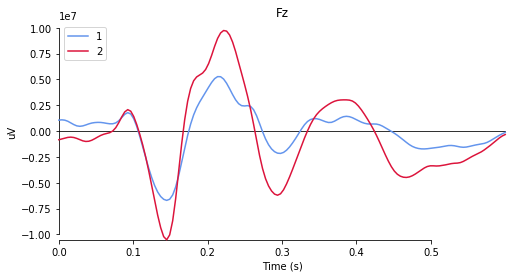

In [16]:
f, ax = plt.subplots(figsize=(8, 4))
mne.viz.plot_compare_evokeds(erp_list, picks='Fz', colors={"1":'CornFlowerBlue', '2':'Crimson'}, axes=ax); 

# Run the graph as a branch, chunk by chunk, to mimick a scheduler
![oddball.png](img/oddball.png)
Here, all is happening *as if* we were online, the helper `ReadData` , used to replay the EEG data can be seen as a device and the loop across chunk, can be seen as a scheduler. 



When one is prototyping a pipeline (developping custom nodes, writting a graph, .. ), it is very usefull to be able to loop *manually*, allowing him to use debug breakpoints, and check that each `update` of each node produces the result he expects. 

In [17]:
from timeflux.helpers.testing import ReadData
import time 

branch = Branch(graph_standalone)
read_data = ReadData(eeg)
chunk_size = 200
n_chunks = np.inf  #np.inf # number of chunks to loop on 

In [18]:
targets = []
predictions = []
wait = False 

![oddball.png](img/oddball.png)

In [19]:
k_chunk = 0
while k_chunk==0 or not chunk.empty and k_chunk < n_chunks: 
    if not wait:
        chunk = read_data.next(chunk_size)
        if chunk.empty:
            break
        events_chunk = events[chunk.index[0]:chunk.index[-1]]
        k_chunk+=1
        branch.set_port('dejitter', port_id='i', data=chunk) 
        branch.set_port('epochs', port_id='i_events', data=events_chunk)
        branch.set_port('gate_training', port_id='i_events', data=events_chunk)
        branch.update()
        
        if branch._scheduler._nodes['fit']._thread_status == 'WORKING':
            print('Fitting.. ')
            wait = True
        o_port = branch.get_port('predict', port_id='o') 
        if o_port.ready():
            targets.append(branch.get_port('predict', port_id='i').data.target.values)
            predictions.append(o_port.data)
    else:
        time.sleep(0.001)
        if branch._scheduler._nodes['fit']._thread_status == 'SUCCESS':
            print('Fit successfull :) ')
            wait = False

Fitting.. 
Fit successfull :) 


# Plot the pipeline output classifications
Here, we stored the output labels of the node `predict` in a a list.
We can now compare the probabilities against the true target class. 

In [20]:
predictions_df = pd.concat(predictions)
predictions_df.loc[:, 'targets'] = np.hstack(targets)

In [21]:
melt_predictions_df = predictions_df.melt(["targets"], value_name='predicted_proba', var_name='predicted_class')
melt_predictions_df.head(3)

,targets,predicted_class,predicted_proba
0,False,False,0.799346
1,False,False,0.826198
2,False,False,0.886469


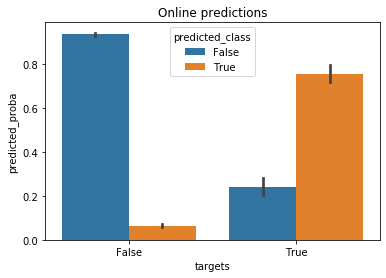

In [22]:
sns.barplot(data=melt_predictions_df, x='targets', y='predicted_proba', hue='predicted_class')
plt.title('Online predictions');

We can plot the confusion matrix of the classification. 

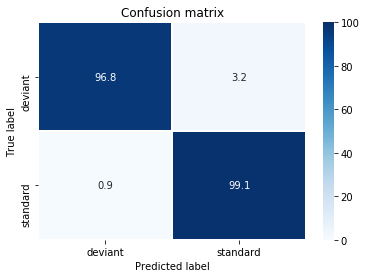

In [23]:
%matplotlib inline 
from pyriemann.utils.viz import plot_confusion_matrix

plot_confusion_matrix((predictions_df['True']>predictions_df['False']).values.astype(str),  
                      predictions_df['targets'].values, ['deviant', 'standard']);
plt.ylim([2, 0]); 